In [2]:
import numpy as np
import corner

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from matplotlib import cm
cmap = plt.cm.get_cmap('viridis_r')
#cmap = matplotlib.colormaps.get_cmap('viridis_r')

# Ignore warning
import warnings
import logging

logging.getLogger('matplotlib').setLevel(logging.ERROR)
warnings.filterwarnings("ignore",category=matplotlib.MatplotlibDeprecationWarning)

# Get plot params

from plot_params import params
pylab.rcParams.update(params)

# Set default colors to load at will
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline

## Load data

In [4]:
betas = np.load("../data/betas.npy")
hods = np.load("../data/hods.npy")
fit_betas = np.load("../data/fit_betas_P+B.npy").T

betas.shape, hods.shape, fit_betas.shape

((10500, 5, 127), (10500, 10), (10500, 6))

## Train density estimators

In [5]:
import torch

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

from tqdm import tqdm

In [6]:
X_samples = torch.tensor(fit_betas, dtype=torch.float32)
Y_samples = torch.tensor(hods[:, :-2], dtype=torch.float32)

In [7]:
def get_flow(d_in=2, d_context=12, d_hidden=32, n_layers=4):
    """ Instantiate a simple (Masked Autoregressive) normalizing flow.
    """

    base_dist = StandardNormal(shape=[d_in])

    transforms = []
    for _ in range(n_layers):
        transforms.append(ReversePermutation(features=d_in))
        transforms.append(MaskedAffineAutoregressiveTransform(features=d_in, 
                                                              hidden_features=d_hidden,
                                                              context_features=d_context))
    transform = CompositeTransform(transforms)

    flow = Flow(transform, base_dist)
    return flow

In [8]:
def train_flow(flow, X, Y=None, batch_size=64, n_steps=5001, lr = 1e-3):
    """ Convenience function for training the normalizing flow transformation
    """
    optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
    
    # Run specified number of optimization steps
    for i_step in tqdm(range(n_steps)):
        
        optimizer.zero_grad()
        
        # Draw random batches and compute their log-probability
        idxs = np.random.choice(X.shape[0], batch_size) 
        if Y is not None:
            loss = -flow.log_prob(X[idxs,:], Y[idxs,:]).mean()
        else:
            loss = -flow.log_prob(X[idxs,:]).mean()

        loss.backward()
        optimizer.step()

    return -flow.log_prob(X_samples[:100], Y_samples[:100]).mean() if Y is not None else -flow.log_prob(X_samples[:100]).mean()


## $p(\beta\mid\mathrm{HOD})$

In [14]:
d_in = X_samples.shape[-1]
d_context = Y_samples.shape[-1]

flow = get_flow(d_in=d_in, d_context=d_context, d_hidden=128, n_layers=6)
train_flow(flow, X_samples, Y_samples, batch_size=64, n_steps=10001, lr=3e-4)

100%|██████████| 10001/10001 [01:23<00:00, 119.46it/s]


tensor(-11.3835, grad_fn=<NegBackward0>)

In [15]:
samples_1 = flow.sample(context=(Y_samples.mean(0) - 0 * Y_samples.std(0)) [None, ...], num_samples=100_000)
samples_2 = flow.sample(context=(Y_samples.mean(0) + 1 * Y_samples.std(0)) [None, ...], num_samples=100_000)

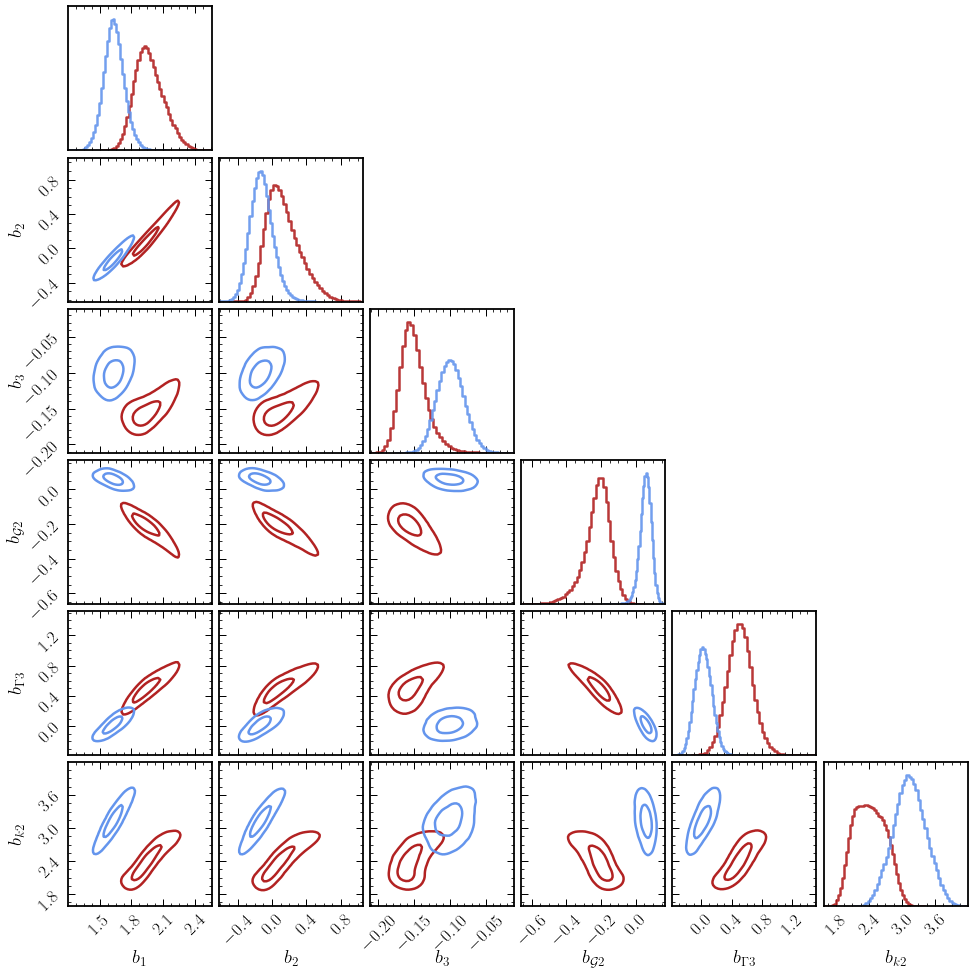

In [19]:
levels =  1.0 - np.exp(-0.5 *np.array([1.0, 2.0]) ** 2)

corner_configs = {
    "smooth": 1.,
    "smooth1d": 0.75,
    "bins": 50,
    "levels": levels, # Assuming 'levels' is defined elsewhere
    "plot_datapoints": False,
    "plot_density": False,
    "labels": [r'$b_1$', r'$b_2$', r'$b_3$', r'$b_{\mathcal G2}$', r'$b_{\Gamma3}$', r'$b_{k2}$']
}

fig = corner.corner(samples_1.detach().numpy(), **corner_configs, color='firebrick');
corner.corner(samples_2.detach().numpy(), **corner_configs, fig=fig, color='cornflowerblue');

In [22]:
torch.save(flow, "../data/models/p_beta_hod.pt")

## $p(\beta)$

In [27]:
d_in = X_samples.shape[-1]

flow = get_flow(d_in=d_in, d_context=0, d_hidden=128, n_layers=6)
train_flow(flow, X_samples, batch_size=64, n_steps=10001, lr=3e-4)

100%|██████████| 10001/10001 [01:08<00:00, 145.40it/s]


tensor(-3.6589, grad_fn=<NegBackward0>)

In [28]:
samples = flow.sample(num_samples=100_000)

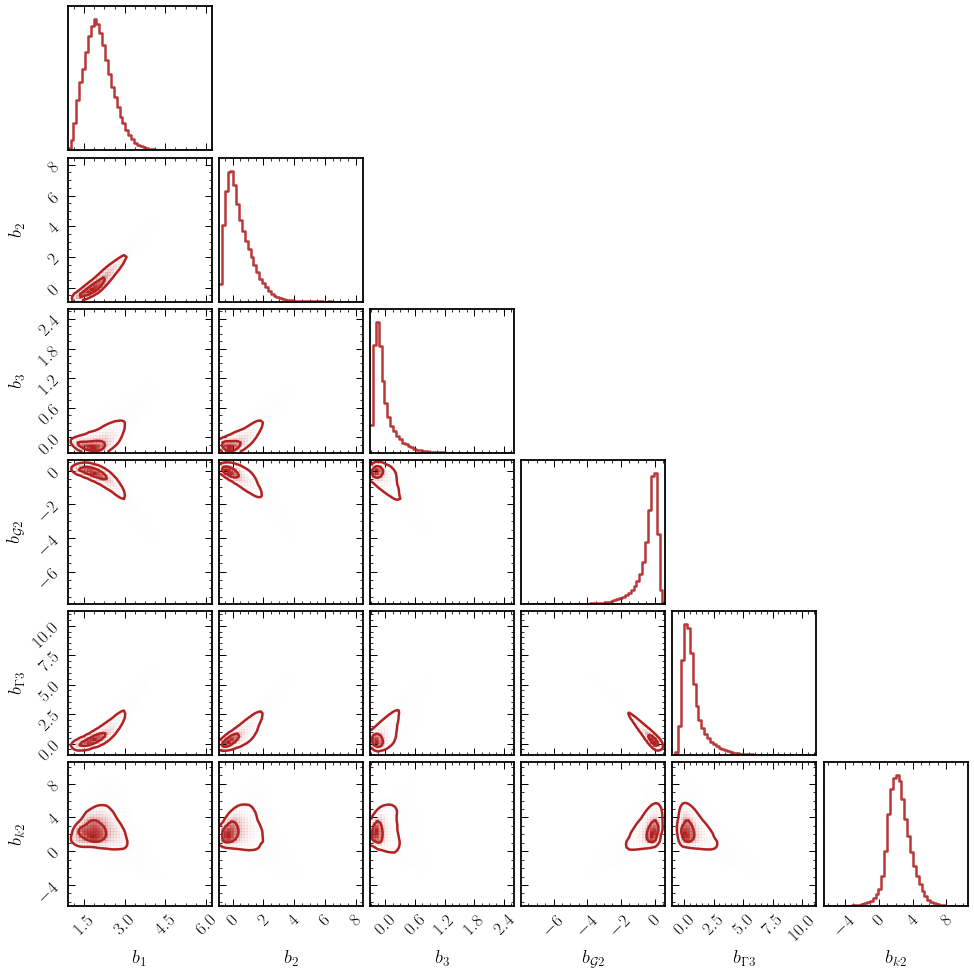

In [29]:
levels =  1.0 - np.exp(-0.5 *np.array([1.0, 2.0]) ** 2)

corner_configs = {
    "smooth": 0.75,
    "smooth1d": 0.5,
    "bins": 50,
    "levels": levels, # Assuming 'levels' is defined elsewhere
    "plot_datapoints": False,
    "plot_density": True,
    "labels": [r'$b_1$', r'$b_2$', r'$b_3$', r'$b_{\mathcal G2}$', r'$b_{\Gamma3}$', r'$b_{k2}$']
}

fig = corner.corner(samples.detach().numpy(), **corner_configs, color='firebrick');

In [30]:
torch.save(flow, "../data/models/p_beta.pt")